In [ ]:
import pandas as pd

import _background as bg
import molNet
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader
from molNet.featurizer.atom_featurizer import atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, \
    atom_is_aromatic, atom_is_in_ring, atom_symbol_one_hot_from_set
from molNet.featurizer.featurizer import FeaturizerList
import pytorch_lightning as pl
import torch

In [ ]:
dataset = pd.read_csv("data/functional_groups.csv")
dataset=dataset.iloc[:1000]

In [ ]:
ys=list(dataset.columns)
ys.remove("smiles")
yar=[]

for i,d in dataset.iterrows():
    yar.append(d[ys].values[None,:])
dataset["y"]=yar
#dataset[["y"]]
#dataset

In [4]:
dataset["rd_mol"]=dataset["smiles"].apply(bg.MolFromSmiles)
c_mp_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)


featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_formal_charge,
    atom_partial_charge,
    atom_hybridization_one_hot,
    atom_is_in_ring,
    atom_is_aromatic,
])

In [5]:
yar[0].size

42

In [6]:
loader_FGModel1 = PytorchGeomMolDfLoader(dataset,
                                         y_columns=["y"],
                                         columns=[],
                                         atom_featurizer=featurizer,
                                         seed=1,
                                         batch_size=128,
                                         )


In [7]:
loader_FGModel1.setup()
for d in loader_FGModel1.test_dataloader():
    print(d)
    break

Batch(batch=[4816], edge_index=[2, 9956], x=[4816, 22], x_graph_features=[128, 0], y=[4816, 0], y_graph_features=[128, 42])


In [8]:
class FGModel1(pl.LightningModule):
    def __init__(self,in_size,out_size,name="none",n_chem_layer=6,chem_layer_feats_out=40,chem_layer_gc_out=30,chem_layer_net_sizes=10,chem_layer_net_count=2,
                 collector_net_depth=3,collector_net_depth_red_fac=2,lr=1e-3,poolings=["pool_wsum"]):
        super().__init__()
        self.save_hyperparameters()
        
        #print(self.hparams)
        
        chem_layer=[
            bg.ChemGCLayer(in_size,[chem_layer_net_sizes]*chem_layer_net_count,chem_layer_gc_out,chem_layer_feats_out,bias=False)
        ]
        for n in range(n_chem_layer-1):
            chem_layer.append(bg.ChemGCLayer(chem_layer_feats_out,[chem_layer_net_sizes]*chem_layer_net_count,chem_layer_gc_out,chem_layer_feats_out,bias=False))
        
        self.chem_layer=torch.nn.Sequential(*chem_layer)
        
        
        self.lr = lr
        
        poolings_layer=[]
        for p in poolings:
            if p=="pool_max":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMax())
            elif p=="pool_min":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMin())
            elif p=="pool_mean":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMean())
            elif p=="pool_sum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolSum())
            elif p=="pool_wsum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolWeightedSum(self.chem_layer[-1].feats_out,normalize=False))
            elif p=="pool_nwsum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolWeightedSum(self.chem_layer[-1].feats_out,normalize=True))

            else:
                raise Exception("unknown pooling '{}'".format(p))
        
        self.pooling=molNet.nn.models.graph_convolution.MergedPooling(
            {"pool_{}".format(i):poolings_layer[i] for i in range(len(poolings_layer))}
        )
        
        self.post_pool_norm=torch.nn.Sigmoid()
        
        collector_net = [
            torch.nn.Linear(len(self.pooling)*self.chem_layer[-1].feats_out,max(1,int(len(self.pooling)*self.chem_layer[-1].feats_out/collector_net_depth_red_fac))),
            torch.nn.ReLU()
        ]
        
        for i in range(collector_net_depth-1):
            collector_net.append(torch.nn.Linear(collector_net[-2].out_features,max(1,int(collector_net[-2].out_features/collector_net_depth_red_fac))))
            collector_net.append(torch.nn.ReLU())
        collector_net.append(torch.nn.Linear(collector_net[-2].out_features,out_size))
        
        collector_net.append(torch.nn.Sigmoid())
        self.nn=torch.nn.Sequential(*collector_net)
        
        
        
        self.lossf=torch.nn.MSELoss()#torch.nn.BCEWithLogitsLoss()#

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats,_,_ = self.chem_layer((feats, edges, batch))

        y_hat = self.pooling(feats,batch)
        y_hat = self.post_pool_norm(y_hat)
        y_hat = self.nn(y_hat)
        return y_hat
      
    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.x_graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def batch_to_loss(self,batch):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y_graph_features)
        return loss

    def training_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('test_loss', loss)
        return loss

model_FGModel1 = FGModel1(in_size=len(featurizer),out_size=yar[0].size)

In [9]:
model_FGModel1 = FGModel1(in_size=len(featurizer),
                          out_size=yar[0].size,
                              n_chem_layer = 3,
                              chem_layer_feats_out=25,
                              chem_layer_gc_out=20,
                              chem_layer_net_sizes=8,
                              chem_layer_net_count=1,
                              collector_net_depth=3,
                              collector_net_depth_red_fac=1,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum"],
                              lr=0.001,
                             )

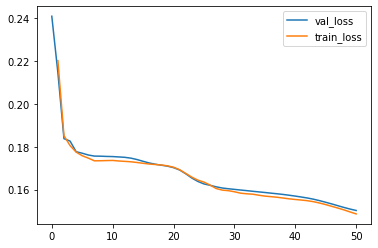

Epoch 50, global step 305: val_loss reached 0.15028 (best 0.15028), saving model to "models/FGModel1/logs/tensorboard/default/version_14/checkpoints/epoch=50-step=305.ckpt" as top 1
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a test_step but have no test_dataloader. Skipping test loop
  warnings.warn(*args, **kwargs)


(0,) (6300,)


ValueError: x and y must have same first dimension, but have shapes (0,) and (6300,)

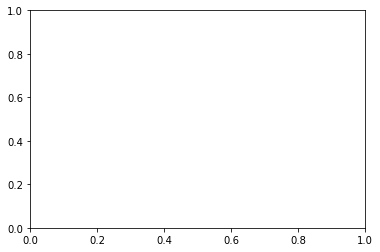

In [10]:
model_FGModel1,data_FGModel1 = bg.default_model_run(
        "FGModel1",
        model_FGModel1,
        loader_FGModel1,
                      force_run=True,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=250,
                    early_stopping_delta=1,
                   detect_lr=False,
                    early_stop_patience=50,

    )

In [ ]:
#list(model_FGModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_FGModel1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

In [ ]:
true=[]
pred=[]
try:
    loader_FGModel1.train_dataloader()
except:
    loader_FGModel1.setup()
    
for l in [
        loader_FGModel1.train_dataloader(),
          loader_FGModel1.val_dataloader(),
          loader_FGModel1.test_dataloader()
         ]:
    for d in l:
        pred.extend(model_FGModel1(d).detach().flatten().numpy().tolist())
        true.extend(d.y.flatten().numpy().tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)

In [ ]:
dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())

plt.plot([dmin-273,dmax-273],[dmin-273,dmax-273],"--")
plt.plot(true-273,pred-273,"o",alpha=0.3,markeredgecolor="w")
plt.xlabel("true")
plt.ylabel("pred")
plt.show()
plt.close()
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [ ]:
#print(np.abs(np.exp(pred)-np.exp(true)).mean())
print(np.abs(pred-true).mean())

In [ ]:
model_FGModel1